Louis Orozco
Project 2
11/6/2024
CMP-262

In [3]:
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import time
from io import StringIO
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Function that webscrapes data for teams stats for the 2020-2023 seasons. 

In [7]:
def fetch_season_data(season):
    url = f"https://www.pro-football-reference.com/years/{season}#team_stats"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all comment blocks in the HTML
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))
        
        # Iterate through comments to find the one containing the table
        table_soup = None
        for comment in comments:
            if "div_team_stats" in comment or "team_stats" in comment:
                table_soup = BeautifulSoup(comment, 'html.parser')
                break
        
        # If table_soup is found, proceed to extract the table data
        if table_soup:
            table = table_soup.find("table", {"id": "team_stats"})
            
            if table is not None:
                headers = []
                # Extract headers from multiple header rows
                for header_row in table.find_all("tr"):
                    row_headers = [header.text.strip() for header in header_row.find_all("th")]
                    if row_headers:
                        headers.append(row_headers)

                # Handle multi-level header by combining parts from each header row
                if len(headers) >= 2:
                    max_length = max(len(headers[0]), len(headers[1]))
                    flat_headers = []
                    for i in range(max_length):
                        part1 = headers[0][i] if i < len(headers[0]) else ""
                        part2 = headers[1][i] if i < len(headers[1]) else ""
                        flat_headers.append(" ".join([part1, part2]).strip())
                else:
                    flat_headers = headers[0] if headers else []

                # If the first header column is empty, remove it
                if flat_headers and flat_headers[0] == "":
                    flat_headers = flat_headers[1:]

                # Rename the columns for '1stD' columns (Passing and Rushing)
                if "1stD" in flat_headers:
                    passing_1stD_index = flat_headers.index("1stD")
                    rushing_1stD_index = flat_headers.index("1stD", passing_1stD_index + 1)  # Find the second "1stD" column
                    
                    flat_headers[passing_1stD_index] = "Passing 1stD"
                    flat_headers[rushing_1stD_index] = "Rushing 1stD"

                # Extract rows and ensure each row matches the number of headers
                rows = []
                for row in table.find_all("tr")[2:]:  # Skip the header rows
                    columns = row.find_all("td")
                    row_data = [col.text.strip() for col in columns]
                    if row_data:
                        # Ensure the number of columns in each row matches the header
                        if len(row_data) == len(flat_headers):
                            rows.append(row_data)
                        else:
                            # Handle mismatch: either truncate or add placeholders
                            while len(row_data) < len(flat_headers):
                                row_data.insert(0, '')  # Insert empty value at the start
                            rows.append(row_data[:len(flat_headers)])  # Truncate if too long

                # Convert to DataFrame
                df = pd.DataFrame(rows, columns=flat_headers)
                
                # Return the dataframe for this season
                return df
            else:
                print(f"Table not found for the {season} season.")
        else:
            print(f"Comment containing the table was not found for the {season} season.")
    else:
        print(f"Failed to retrieve the webpage for {season}. Status code: {response.status_code}")
    return None

# Loop through seasons 2020-2023 and fetch the data
seasons = [2020, 2021, 2022, 2023]
all_seasons_data = {}

for season in seasons:
    df_season = fetch_season_data(season)
    if df_season is not None:
        # Store each season's data in a dictionary
        all_seasons_data[season] = df_season

Create a scatter plot of the data for a teams Points For and number of penelties and create a regression line for the 2020-2023 seasons. 

Pearson Correlation for season 2020: 0.12579239962141042


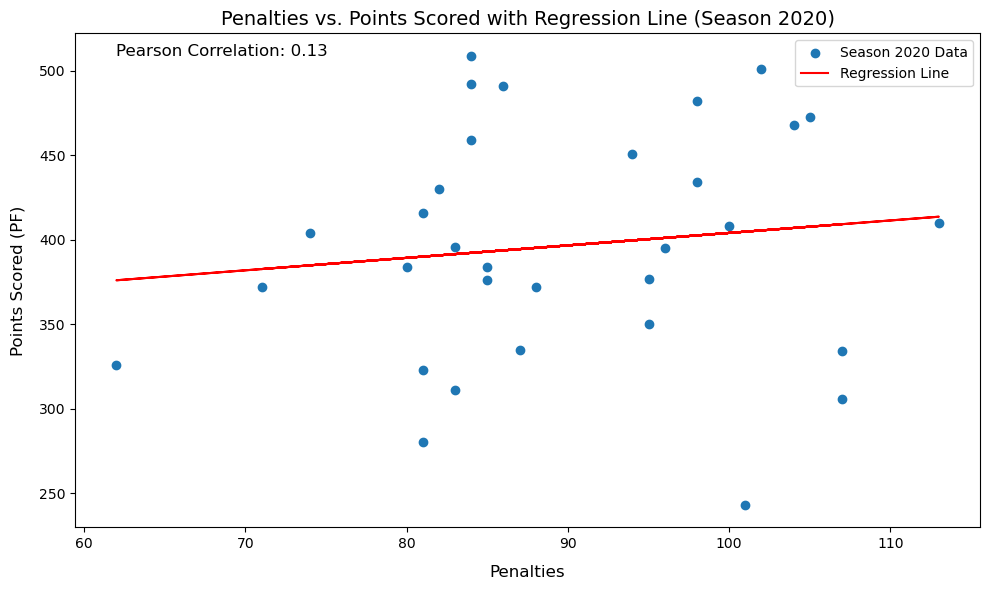

Pearson Correlation for season 2021: 0.011558855096695199


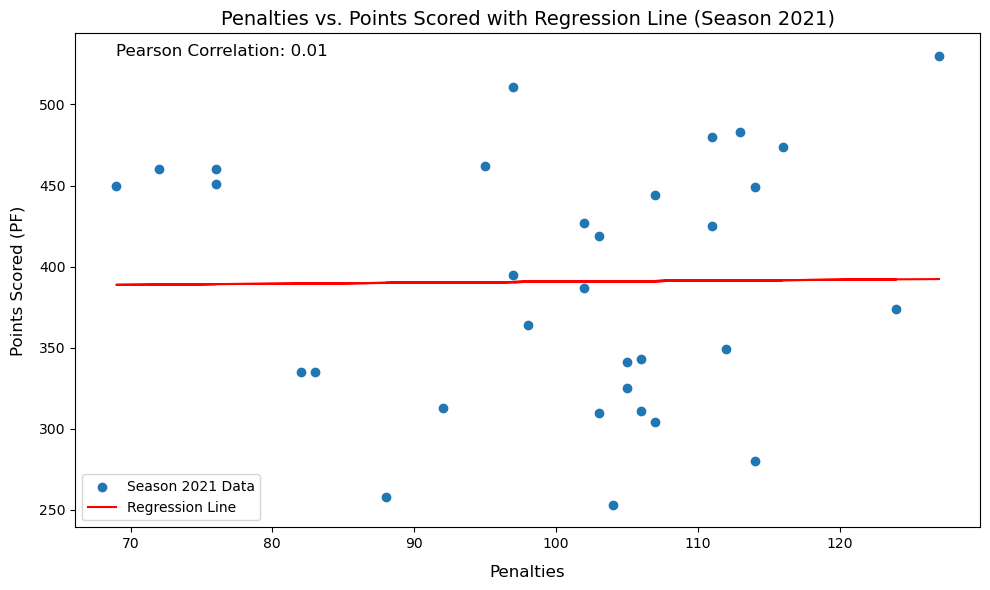

Pearson Correlation for season 2022: -0.08468957792794962


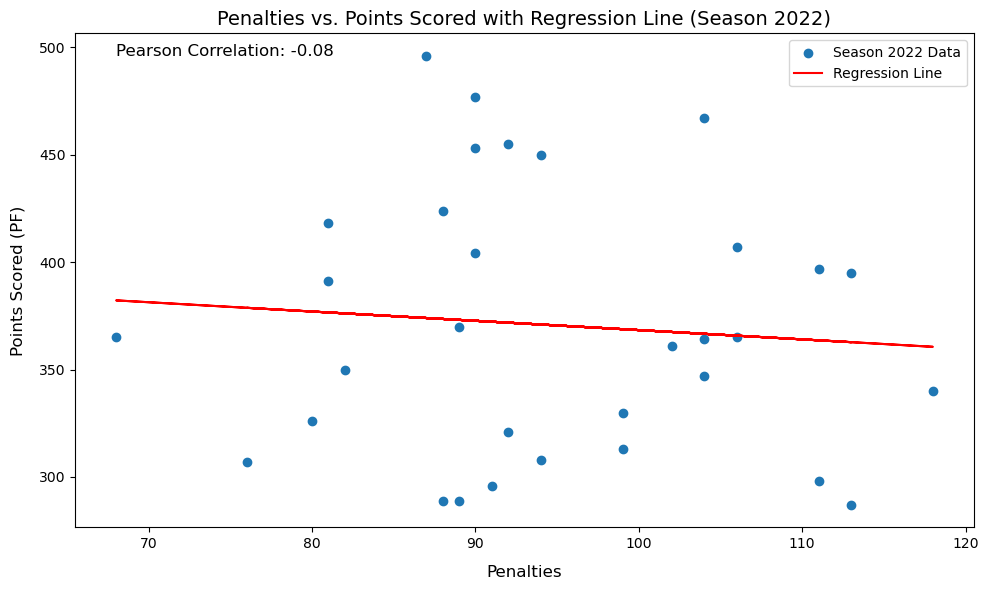

Pearson Correlation for season 2023: 0.1836747519413991


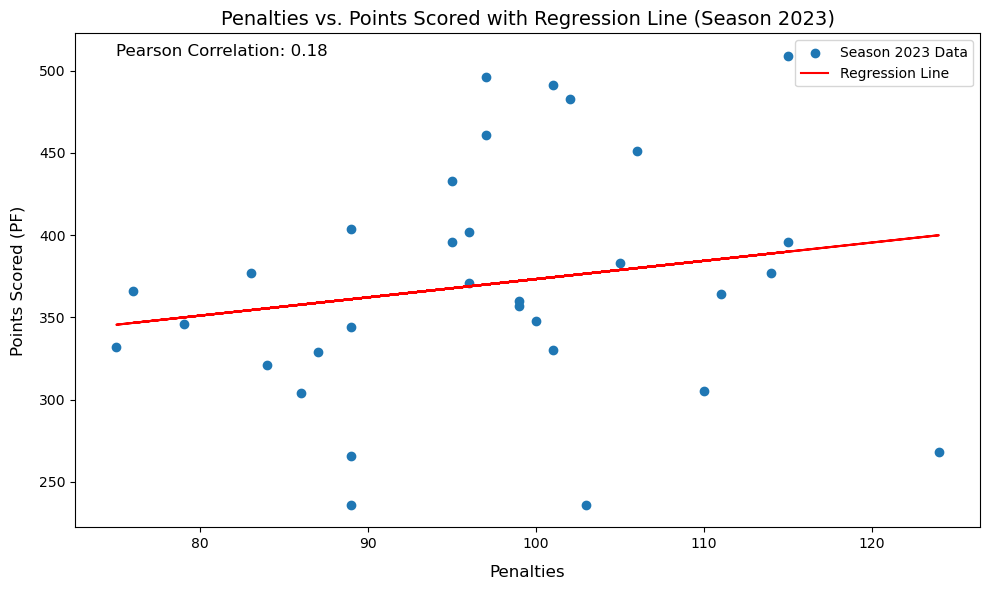

In [261]:
# Assuming all_seasons_data contains DataFrames for each season
# Example: all_seasons_data = {2020: df_2020, 2021: df_2021, 2022: df_2022, 2023: df_2023}

penalties_column = 'Pen'  # Replace with actual column name for penalties
scoring_column = 'PF'  # Replace with actual column name for points scored

unwanted_teams = ['Avg Team', 'League Total', 'Avg Tm/G']

# Iterate over each season's DataFrame in the all_seasons_data dictionary
for season, df in all_seasons_data.items():
    # Step 1: Ensure the relevant columns are numeric
    df[penalties_column] = pd.to_numeric(df[penalties_column], errors='coerce')
    df[scoring_column] = pd.to_numeric(df[scoring_column], errors='coerce')

    # Step 2: Drop rows with missing values in the relevant columns
    df_cleaned = df.dropna(subset=[penalties_column, scoring_column])

    # Remove rows where the team name is in the unwanted list
    df_cleaned = df_cleaned[~df_cleaned['Tm'].isin(unwanted_teams)]

    # Sort the data for better visualization
    sorted_penalties = df_cleaned[penalties_column].sort_values(ascending=True).reset_index(drop=True)
    sorted_scoring = df_cleaned[scoring_column].sort_values(ascending=True).reset_index(drop=True)
    
    penalties = df_cleaned[penalties_column].values.reshape(-1, 1)
    scoring = df_cleaned[scoring_column].values

    # Calculate the Pearson correlation
    correlation = np.corrcoef(penalties.flatten(), scoring)[0, 1]
    print(f"Pearson Correlation for season {season}: {correlation}")

    # Fit linear regression model
    regressor = LinearRegression()
    regressor.fit(penalties, scoring)

    # Get the regression line
    line = regressor.predict(penalties)

    # Create the scatter plot for each season
    plt.figure(figsize=(10, 6))  # Increase the figure size to give more space for the labels
    plt.scatter(penalties, scoring, label=f'Season {season} Data')

    # Plot the regression line
    plt.plot(penalties, line, color='red', label='Regression Line')

    # Set labels and title
    plt.xlabel('Penalties', fontsize=12, labelpad=10)  # Increase label padding to prevent overlap
    plt.ylabel('Points Scored (PF)', fontsize=12, labelpad=10)  # Increase label padding to prevent overlap
    plt.title(f'Penalties vs. Points Scored with Regression Line (Season {season})', fontsize=14)

    # Show the correlation value in the plot
    plt.text(min(penalties), max(scoring), f'Pearson Correlation: {correlation:.2f}', fontsize=12)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.legend()
    plt.show()

Create a plot of all the regression lines and the average regression for the 2020-2023 seasons. 

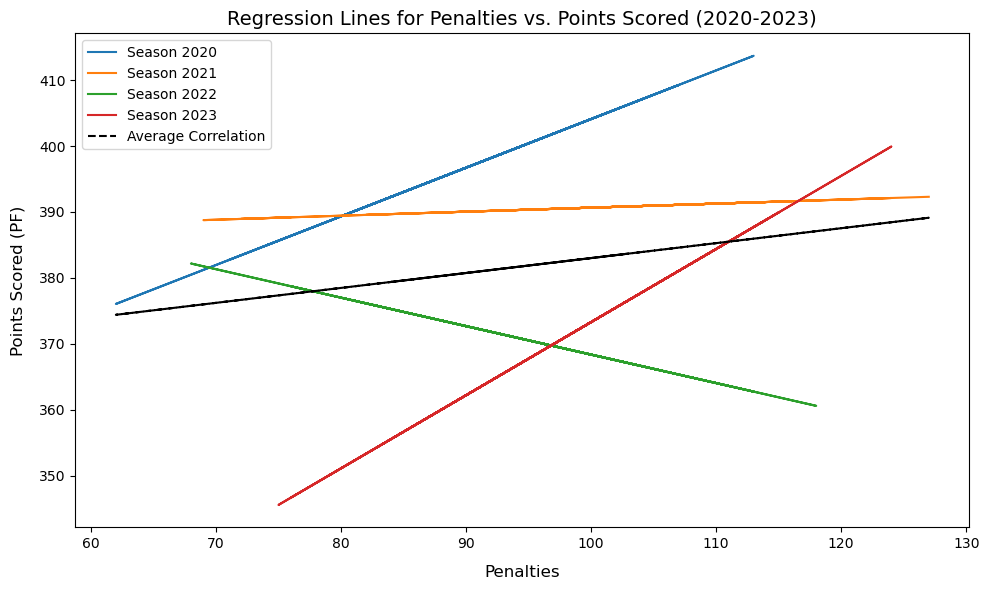

In [271]:
penalties_column = 'Pen'  # Replace with actual column name for penalties
scoring_column = 'PF'  # Replace with actual column name for points scored

unwanted_teams = ['Avg Team', 'League Total', 'Avg Tm/G']

plt.figure(figsize=(10, 6))  # Create a single figure for all the lines

# Lists to store penalties and scoring data for all seasons to calculate the average line
all_penalties = []
all_scoring = []

# Iterate over each season's DataFrame in the all_seasons_data dictionary
for season, df in all_seasons_data.items():
    # Step 1: Ensure the relevant columns are numeric
    df[penalties_column] = pd.to_numeric(df[penalties_column], errors='coerce')
    df[scoring_column] = pd.to_numeric(df[scoring_column], errors='coerce')

    # Step 2: Drop rows with missing values in the relevant columns
    df_cleaned = df.dropna(subset=[penalties_column, scoring_column])

    # Remove rows where the team name is in the unwanted list
    df_cleaned = df_cleaned[~df_cleaned['Tm'].isin(unwanted_teams)]

    penalties = df_cleaned[penalties_column].values.reshape(-1, 1)
    scoring = df_cleaned[scoring_column].values

    # Store the data for the average calculation
    all_penalties.extend(penalties.flatten())
    all_scoring.extend(scoring)

    # Fit linear regression model for each season
    regressor = LinearRegression()
    regressor.fit(penalties, scoring)

    # Get the regression line for each season
    line = regressor.predict(penalties)

    # Plot the regression line for each season
    plt.plot(penalties, line, label=f'Season {season}')

# Calculate the average correlation line across all seasons
average_penalties = np.array(all_penalties).reshape(-1, 1)
average_scoring = np.array(all_scoring)

# Fit a linear regression model for the average data
average_regressor = LinearRegression()
average_regressor.fit(average_penalties, average_scoring)

# Get the average regression line
average_line = average_regressor.predict(average_penalties)

# Plot the average regression line
plt.plot(average_penalties, average_line, color='black', linestyle='--', label='Average Correlation')

# Set labels and title
plt.xlabel('Penalties', fontsize=12, labelpad=10)  # Increase label padding to prevent overlap
plt.ylabel('Points Scored (PF)', fontsize=12, labelpad=10)  # Increase label padding to prevent overlap
plt.title('Regression Lines for Penalties vs. Points Scored (2020-2023)', fontsize=14)

# Show the legend
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

When looking at the correlation over the 2020-2023 seasons while it appears that in some seasons there was a weak postive correlation when you look at the correlations as a whole for all season the corrlation between Penelties and Points For is closer to 0 and it appears they have no realationship. Which is supprising as in general penalites are considered a large negative when it comes to a teams offensive production so we would expect that the correlation would be negative(teams with more penalties score less points) but this immmplies the oppisote is true more often. A possible explination for this is that a team the is more successful on offense also had more offensive plays so more oppurunites to commit a penelty. 

<h3>Do teams with less turnovers win more?</h3>

Webscrape tables for the AFC teams for the 2020-2023 seasons. 

In [53]:
# List of URLs for AFC 2020-2023 season pages
urls_afc = [
    "https://www.pro-football-reference.com/years/2020/#AFC",
    "https://www.pro-football-reference.com/years/2021/#AFC",
    "https://www.pro-football-reference.com/years/2022/#AFC",
    "https://www.pro-football-reference.com/years/2023/#AFC"
]

# Create a dictionary to hold separate DataFrames for each season
season_dfs_afc = {}

# Loop over the URLs to scrape each season's data
for url in urls_afc:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the AFC table using id="AFC"
    afc_table = soup.find('table', {'id': 'AFC'})

    # If the table is found, process it
    if afc_table:
        # Convert the HTML to a string and wrap it in StringIO
        afc_html = str(afc_table)
        afc_df = pd.read_html(StringIO(afc_html))[0]
        
        # Extract the season year from the URL
        season_year = url.split('/')[4].split('#')[0]

        # Add the DataFrame to the dictionary, using the season as the key
        season_dfs_afc[season_year] = afc_df
    else:
        print(f"AFC table not found for {url}")



Webscrape data for NFC teams for the 2020-2023 seasons.

In [55]:
# List of URLs for NFC 2020-2023 season pages
urls = [
    "https://www.pro-football-reference.com/years/2020/#NFC",
    "https://www.pro-football-reference.com/years/2021/#NFC",
    "https://www.pro-football-reference.com/years/2022/#NFC",
    "https://www.pro-football-reference.com/years/2023/#NFC"
]

# Create a dictionary to hold separate DataFrames for each season
season_dfs_nfc = {}

# Loop over the URLs to scrape each season's data
for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the NFC table using id="NFC"
    nfc_table = soup.find('table', {'id': 'NFC'})

    # If the table is found, process it
    if nfc_table:
        # Convert the HTML to a string and wrap it in StringIO
        nfc_html = str(nfc_table)
        nfc_df = pd.read_html(StringIO(nfc_html))[0]
        
        # Extract the season year from the URL
        season_year = url.split('/')[4].split('#')[0]

        # Add the DataFrame to the dictionary, using the season as the key
        season_dfs_nfc[season_year] = nfc_df
    else:
        print(f"NFC table not found for {url}")


Create a data frame of a teams wins and there turnovers taken from the team_stats dataframes the correlate the data for the 2020-2023 seasons. 

In [379]:
correlations = {}

# Iterate over seasons 2020-2023
for season in ['2020', '2021', '2022', '2023']:
    # Merge the AFC and NFC data for the current season
    df_afc = season_dfs_afc.get(season)
    df_nfc = season_dfs_nfc.get(season)
    
    if df_afc is not None and df_nfc is not None:
        
        # Rename columns if necessary to make sure 'Tm' is the team column
        df_afc = df_afc.rename(columns={df_afc.columns[0]: 'Tm', df_afc.columns[1]: 'Wins'})
        df_nfc = df_nfc.rename(columns={df_nfc.columns[0]: 'Tm', df_nfc.columns[1]: 'Wins'})

        # Combine the AFC and NFC data
        season_df = pd.concat([df_afc[['Tm', 'Wins']], df_nfc[['Tm', 'Wins']]], ignore_index=True)

        # Assuming 'Passing TO' is the column for turnovers, for season data you would merge it with the season's 'team_stats' data
        df_turnovers = fetch_season_data(season)  # Replace with actual data fetching function

        # Merge the turnover data with the combined AFC and NFC data
        merged_df = pd.merge(season_df, df_turnovers[['Tm', 'Passing TO']], on='Tm', how='inner')

        # Clean the data: remove aggregate rows like "Avg Team", "League Total"
        merged_df = merged_df[~merged_df['Tm'].isin(['Avg Team', 'League Total'])]

        # Convert columns to numeric
        merged_df['Passing TO'] = pd.to_numeric(merged_df['Passing TO'], errors='coerce')
        merged_df['Wins'] = pd.to_numeric(merged_df['Wins'], errors='coerce')

        # Drop rows with missing values
        merged_df = merged_df.dropna()

        # Calculate the correlation for this season
        correlation = merged_df['Passing TO'].corr(merged_df['Wins'])
        
        # Store the correlation in the dictionary
        correlations[season] = correlation

# Print the correlations for all seasons
for season, correlation in correlations.items():
    print(f"Correlation for {season} season: {correlation:.2f}")

Correlation for 2020 season: -0.09
Correlation for 2021 season: -0.48
Correlation for 2022 season: -0.72
Correlation for 2023 season: -0.11


There does seem to be to a correlation between turnovers and wins, teams that turned the ball over more tended to win less. But some seasons seem to show a stronger correlation than others as the 2020 and 2023 season had very little correlation where ther 2021 and 2022 seasons had stronger correlations. 

<h3>How has a teams rushing and passing changed over time? </h3>

Function to fetch data from passing table for 2020-2023 seasons.

In [21]:
def fetch_team_passing_stats(year):
    url = f"https://www.pro-football-reference.com/years/{year}/#passing"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))
        
        # Locate the passing stats table in the comments
        passing_table_html = None
        for comment in comments:
            if "passing" in comment and "id" in comment:
                passing_table_html = BeautifulSoup(comment, 'html.parser')
                break
        
        if passing_table_html:
            table = passing_table_html.find("table", {"id": "passing"})
            if table:
                # Extract headers
                headers = []
                for header_row in table.find_all("tr"):
                    row_headers = [header.text.strip() for header in header_row.find_all("th")]
                    if row_headers:
                        headers.append(row_headers)

                # Combine header rows if necessary
                if len(headers) >= 2:
                    max_length = max(len(headers[0]), len(headers[1]))
                    combined_headers = []
                    for i in range(max_length):
                        part1 = headers[0][i] if i < len(headers[0]) else ""
                        part2 = headers[1][i] if i < len(headers[1]) else ""
                        combined_headers.append(" ".join([part1, part2]).strip())
                else:
                    combined_headers = headers[0] if headers else []

                if combined_headers and combined_headers[0] == "":
                    combined_headers = combined_headers[1:]

                # Extract data rows
                data_rows = []
                for row in table.find_all("tr")[2:]:
                    columns = row.find_all("td")
                    row_data = [col.text.strip() for col in columns]
                    if row_data:
                        while len(row_data) < len(combined_headers):
                            row_data.insert(0, '')
                        data_rows.append(row_data[:len(combined_headers)])

                # Convert to DataFrame
                passing_stats_df = pd.DataFrame(data_rows, columns=combined_headers)

                # Remove rows where the 'Tm' column contains specific unwanted values
                passing_stats_df = passing_stats_df[~passing_stats_df['Tm'].isin(['Avg Team', 'League Total', 'Avg Tm/G'])]

                return passing_stats_df
            else:
                print(f"No table found for passing stats in {year}.")
        else:
            print(f"No comment found containing passing stats table for {year}.")
    else:
        print(f"Failed to retrieve data for {year}. Status code: {response.status_code}")
    return None

# Fetch data for multiple years
years = [2020, 2021, 2022, 2023]
passing_data_by_year = {}

for year in years:
    df_passing = fetch_team_passing_stats(year)
    if df_passing is not None:
        passing_data_by_year[year] = df_passing



Function to fetch data from rushing table for 2020-2023 seasons.

In [23]:
def fetch_team_rushing_stats(year):
    url = f"https://www.pro-football-reference.com/years/{year}/#rushing"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))
        
        # Locate the rushing stats table in the comments
        rushing_table_html = None
        for comment in comments:
            if "rushing" in comment and "id" in comment:
                rushing_table_html = BeautifulSoup(comment, 'html.parser')
                break
        
        if rushing_table_html:
            table = rushing_table_html.find("table", {"id": "rushing"})
            if table:
                # Extract headers
                headers = []
                for header_row in table.find_all("tr"):
                    row_headers = [header.text.strip() for header in header_row.find_all("th")]
                    if row_headers:
                        headers.append(row_headers)

                # Combine header rows if necessary
                if len(headers) >= 2:
                    max_length = max(len(headers[0]), len(headers[1]))
                    combined_headers = []
                    for i in range(max_length):
                        part1 = headers[0][i] if i < len(headers[0]) else ""
                        part2 = headers[1][i] if i < len(headers[1]) else ""
                        combined_headers.append(" ".join([part1, part2]).strip())
                else:
                    combined_headers = headers[0] if headers else []

                if combined_headers and combined_headers[0] == "":
                    combined_headers = combined_headers[1:]

                # Extract data rows
                data_rows = []
                for row in table.find_all("tr")[2:]:
                    columns = row.find_all("td")
                    row_data = [col.text.strip() for col in columns]
                    if row_data:
                        while len(row_data) < len(combined_headers):
                            row_data.insert(0, '')
                        data_rows.append(row_data[:len(combined_headers)])

                # Create a DataFrame
                rushing_stats_df = pd.DataFrame(data_rows, columns=combined_headers)
                return rushing_stats_df
            else:
                print(f"No table found for rushing stats in {year}.")
        else:
            print(f"No comment found containing rushing stats table for {year}.")
    else:
        print(f"Failed to retrieve data for {year}. Status code: {response.status_code}")
    return None

# Fetch data for multiple years
years = [2020, 2021, 2022, 2023]
rushing_data_by_year = {}

for year in years:
    df_rushing = fetch_team_rushing_stats(year)
    if df_rushing is not None:
        rushing_data_by_year[year] = df_rushing


Function that determines a teams ranking in passing and rushing and then calculate the change in rankings from the 2020-2023 seasons. 

In [581]:
def compare_ranking_changes(result_by_year):
    # Prepare a list to store ranking change data
    ranking_changes = {year: pd.DataFrame() for year in result_by_year.keys()}
    
    # Calculate ranking changes for each year
    for year in result_by_year:
        df = result_by_year[year]
        
        # Track rankings for the current year
        passing_rank = df[['Tm', 'Passing Rank']].set_index('Tm')
        rushing_rank = df[['Tm', 'Rushing Rank']].set_index('Tm')

        # Store the ranks for this year
        ranking_changes[year]['Passing Rank'] = passing_rank['Passing Rank']
        ranking_changes[year]['Rushing Rank'] = rushing_rank['Rushing Rank']

    # Create an empty list to hold the rows of the comparison DataFrame
    comparison_data = []

    # Get all teams
    teams = set()
    for year in ranking_changes:
        teams.update(ranking_changes[year].index)

    # Identify the years we need to consider
    years = sorted(ranking_changes.keys())

    # Iterate through teams and years to calculate rank changes
    for team in teams:
        row = {'Team': team}
        
        # Iterate through categories
        for category in ['Passing Rank', 'Rushing Rank']:
            changes = []
            # For each category, calculate rank change over the years
            for year in years:
                if team in ranking_changes[year].index:
                    current_rank = ranking_changes[year].loc[team, category]
                    previous_rank = ranking_changes[year - 1].loc[team, category] if year > min(years) and team in ranking_changes[year - 1].index else None
                    if previous_rank is not None:
                        change = previous_rank - current_rank  # Positive change means rank improved (lower number)
                        changes.append(change)
                    else:
                        changes.append(None)  # If no previous rank, append None
                else:
                    changes.append(None)  # If no rank data for this year, append None

            # Ensure the row for this team/category is the same length as the number of years
            row[f'{category} Change'] = changes

        comparison_data.append(row)

    # Convert the list of rows to a DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    return comparison_df

# Example usage for comparing rankings for the years 2020 to 2023
ranking_changes_df = compare_ranking_changes(result_by_year)


Create a plot for a teams rushing and passing ranking change over the 2020-2023 seaons. 

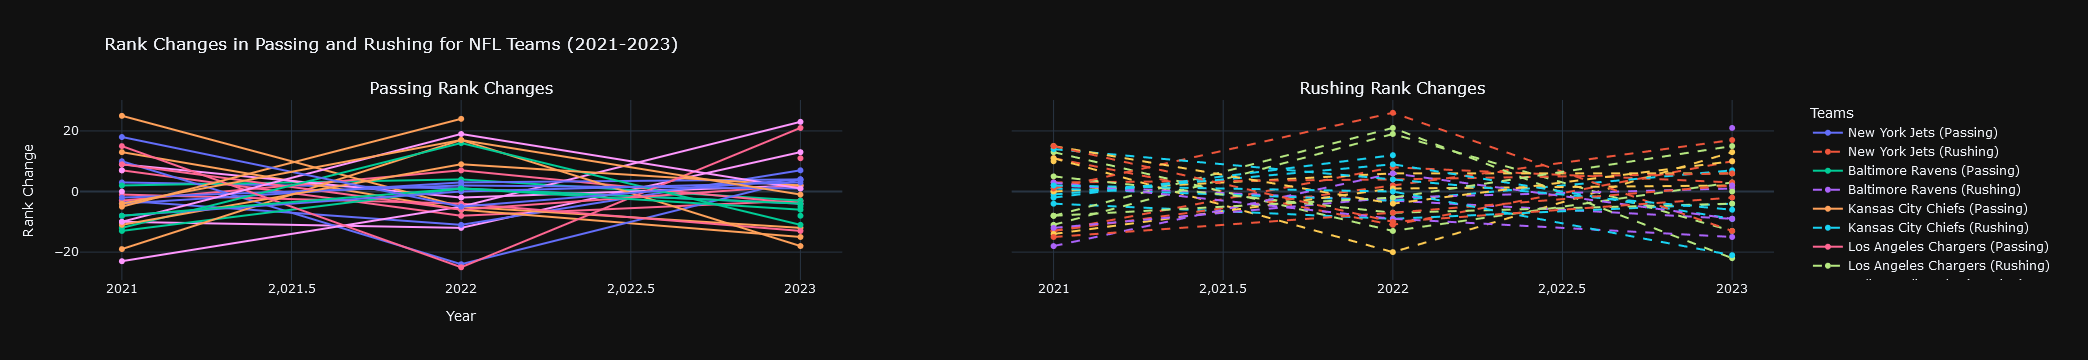

In [576]:
# Set up the years (2021, 2022, 2023)
years = [2021, 2022, 2023]

# Create subplots: One for passing and one for rushing
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Passing Rank Changes", "Rushing Rank Changes"),
    shared_yaxes=True
)

# Loop through each team and add lines for passing and rushing
for i, row in ranking_changes_df.iterrows():
    team = row['Team']
    
    # Get the passing and rushing rank changes for the years 2021, 2022, 2023
    passing_change = row['Passing Rank Change'][1:]  # Skip first element (for 2020)
    rushing_change = row['Rushing Rank Change'][1:]  # Skip first element (for 2020)

    # Replace None with None (Plotly handles NaN)
    passing_change = [None if x is None else x for x in passing_change]
    rushing_change = [None if x is None else x for x in rushing_change]

    # Add passing rank line to the first subplot (left)
    fig.add_trace(go.Scatter(x=years, y=passing_change, mode='lines+markers', name=f'{team} (Passing)'),
                  row=1, col=1)

    # Add rushing rank line to the second subplot (right)
    fig.add_trace(go.Scatter(x=years, y=rushing_change, mode='lines+markers', name=f'{team} (Rushing)', line=dict(dash='dash')),
                  row=1, col=2)

# Update layout
fig.update_layout(
    title='Rank Changes in Passing and Rushing for NFL Teams (2021-2023)',
    xaxis_title='Year',
    yaxis_title='Rank Change',
    legend_title='Teams',
    template='plotly_dark',
    showlegend=True
)

# Show the interactive plot
fig.show()

*Note this is an image of a inteactive graph that cannot be displayed in Github*

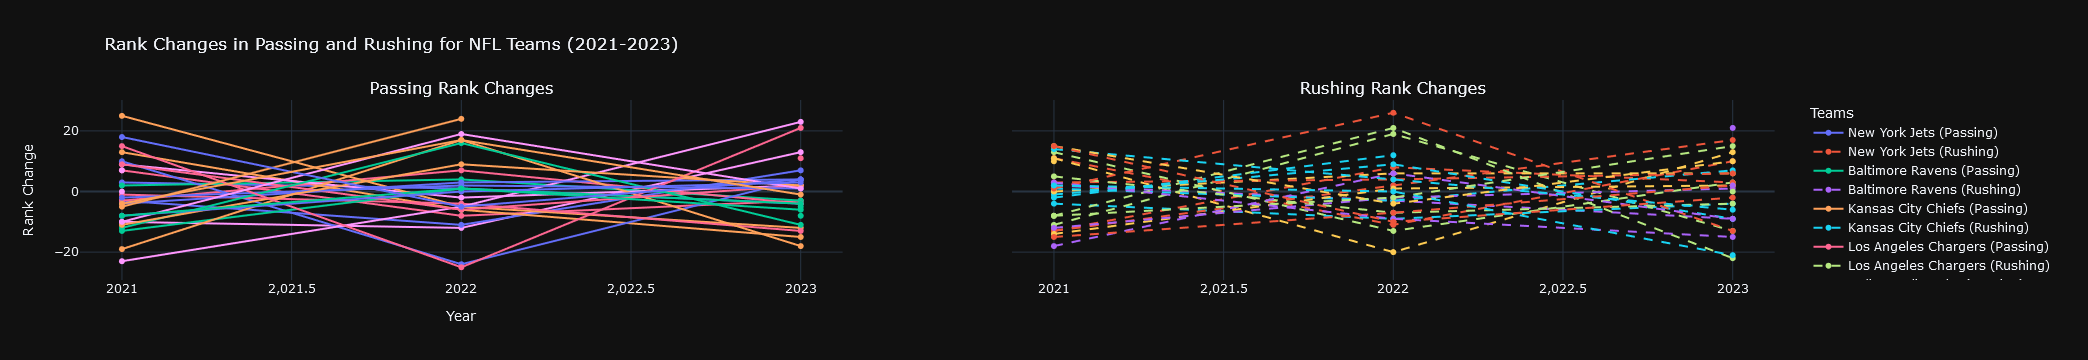

<h3>Does a team do better rushing for first downs or passing for first downs?</h3>

Function to take data for expeted points and 1st downs from passing and rushing, then compare to see if for a given team should they pass, rush or use a balance apporach. 

In [25]:
def analyze_first_down_strategy_for_all_seasons():
    all_results = {}

    # Iterate over all seasons (e.g., 2020-2023)
    for season in [2020, 2021, 2022, 2023]:
        passing_df = passing_data_by_year.get(season)
        rushing_df = rushing_data_by_year.get(season)
        season_df = all_seasons_data.get(season)

        if passing_df is not None and rushing_df is not None and season_df is not None:
            # Rename 'EXP' in passing and rushing dataframes before merging
            passing_df = passing_df.rename(columns={'EXP': 'Passing EXP'})
            rushing_df = rushing_df.rename(columns={'EXP': 'Rushing EXP'})
            
            # Merge the dataframes
            analysis_df = season_df.merge(passing_df[['Tm', 'Passing EXP']], on="Tm", how="left")
            analysis_df = analysis_df.merge(rushing_df[['Tm', 'Rushing EXP']], on="Tm", how="left")


            # Ensure columns have been renamed
            print(f"Analysis Data Columns After Merge for {season}:", analysis_df.columns)

            # Convert columns to numeric, forcing errors to NaN (if any)
            analysis_df["Passing EXP"] = pd.to_numeric(analysis_df["Passing EXP"], errors='coerce')
            analysis_df["Rushing EXP"] = pd.to_numeric(analysis_df["Rushing EXP"], errors='coerce')
            
            # Remove rows where 'Tm' column contains specific unwanted values
            analysis_df = analysis_df[~analysis_df['Tm'].isin(['Avg Team', 'League Total', 'Avg Tm/G'])]
            
            # Alternatively, if NaN values are present in important columns:
            analysis_df = analysis_df.dropna(subset=['Passing EXP', 'Rushing EXP'])

            # Determine strategy based on higher EXP and first downs
            analysis_df["Decision"] = analysis_df.apply(
                lambda row: "Pass" if row["Passing EXP"] > row["Rushing EXP"] and row["Passing 1stD"] > row["Rushing 1stD"]
                            else "Rush" if row["Rushing EXP"] > row["Passing EXP"] and row["Rushing 1stD"] > row["Passing 1stD"]
                            else "Balanced",
                axis=1
            )
            
            # Store the result for this season
            all_results[season] = analysis_df[["Tm", "Passing 1stD", "Rushing 1stD", "Passing EXP", "Rushing EXP", "Decision"]]
        else:
            print(f"Data for the year {season} is incomplete.")
    
    return all_results

In [27]:
# Run the analysis for all seasons
all_seasons_analysis = analyze_first_down_strategy_for_all_seasons()

Analysis Data Columns After Merge for 2020: Index(['Rk', 'Tm', 'G', 'PF', 'Tot Yds & TO Yds', 'Ply', 'Y/P', 'Passing TO',
       'Rushing FL', 'Penalties 1stD', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'NY/A', 'Passing 1stD', 'Att', 'Yds', 'TD', 'Y/A', 'Rushing 1stD',
       'Pen', 'Yds', '1stPy', 'Sc%', 'TO%', 'EXP', 'Passing EXP',
       'Rushing EXP'],
      dtype='object')
Analysis Data Columns After Merge for 2021: Index(['Rk', 'Tm', 'G', 'PF', 'Tot Yds & TO Yds', 'Ply', 'Y/P', 'Passing TO',
       'Rushing FL', 'Penalties 1stD', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'NY/A', 'Passing 1stD', 'Att', 'Yds', 'TD', 'Y/A', 'Rushing 1stD',
       'Pen', 'Yds', '1stPy', 'Sc%', 'TO%', 'EXP', 'Passing EXP',
       'Rushing EXP'],
      dtype='object')
Analysis Data Columns After Merge for 2022: Index(['Rk', 'Tm', 'G', 'PF', 'Tot Yds & TO Yds', 'Ply', 'Y/P', 'Passing TO',
       'Rushing FL', 'Penalties 1stD', 'Cmp', 'Att', 'Yds', 'TD', 'Int',
       'NY/A', 'Passing 1stD', 'Att', 'Yds', 

Function to plot the total of every teams apporach for the 2020-2023 seasons.

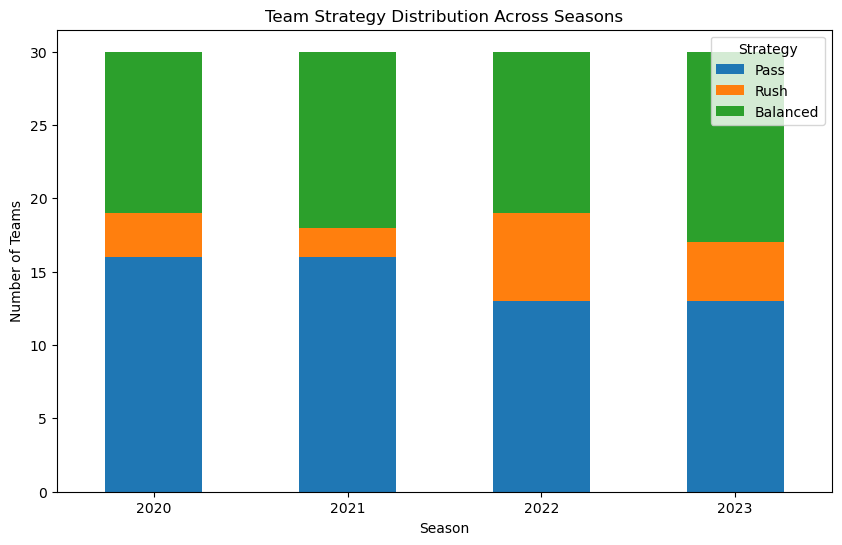

In [479]:
def plot_strategy_distribution(season_analysis):
    strategy_counts = {season: result_df['Decision'].value_counts() for season, result_df in season_analysis.items()}

    # Convert strategy_counts to a DataFrame for easy plotting
    strategy_df = pd.DataFrame(strategy_counts).T.fillna(0)
    strategy_df = strategy_df[['Pass', 'Rush', 'Balanced']]  # Ensure consistent column order
    
    strategy_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title("Team Strategy Distribution Across Seasons")
    plt.xlabel("Season")
    plt.ylabel("Number of Teams")
    plt.xticks(rotation=0)
    plt.legend(title="Strategy", labels=["Pass", "Rush", "Balanced"])
    plt.show()

# Call the function with all_seasons_analysis
plot_strategy_distribution(all_seasons_analysis)

Passing appears to be the better choice for 1st downs for most teams if they wanted to score more points but a balanced approach has become more popular over the seasons. 